In [2]:
import pandas as pd
from pathlib import Path

streams_features_file = r"/Users/James/Documents/Python/Machine Learning Projects/Spotify_Listening_Analysis/Spotify 2.0/preprocessing/pickles/my_features.pkl"
streams_features_raw = pd.read_pickle(streams_features_file)
streams_features = streams_features_raw.copy()


columns_to_drop = ["type", "id", "uri", "track_href", "analysis_url", "time_signature"]
streams_features.drop(columns_to_drop, inplace=True, axis=1)


def convert_duration(dataframe=streams_features):
    dataframe["duration"] = dataframe["duration_ms"].divide(60000)
    dataframe.drop("duration_ms", axis=1, inplace=True)
    return dataframe


def add_play_count(dataframe=streams_features):
    dataframe["playCount"] = dataframe["minutesTotal"] / dataframe["duration"]
    return dataframe


streams_features = convert_duration(streams_features)
streams_features = add_play_count(streams_features)

streams_features = streams_features[
    (streams_features["artistName"] != "John Mayer")
    & (streams_features["trackName"] != "On The Way Home")
]  # this one song has an incorrect duration and is returning a 30+ play count, definitely something not right


In [3]:
def plot_loss(model_history, exp = False):
    if exp:
        plt.plot(pd.DataFrame(np.exp(model_history.history["loss"])), label = "loss")
        plt.plot(pd.DataFrame(np.exp(model_history.history["val_loss"])), label = "val_loss")
    else:
        plt.plot(pd.DataFrame(model_history.history["loss"]), label = "loss")
        plt.plot(pd.DataFrame(model_history.history["val_loss"]), label = "val_loss")
    plt.grid(True)
    #plt.gca().set_ylim(0, 10)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [4]:
def plot_hist(model):
    fig, ax = plt.subplots(figsize=(7,5));
    ax = sns.histplot(data = model, x = "playCount", stat = "count", kde = True)
    return ax

In [5]:
streams_features.count()

artistName          8443
trackName           8443
minutesTotal        8443
trackId             8443
danceability        8443
energy              8443
key                 8443
loudness            8443
mode                8443
speechiness         8443
acousticness        8443
instrumentalness    8443
liveness            8443
valence             8443
tempo               8443
duration            8443
playCount           8443
dtype: int64

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='playCount', ylabel='Count'>

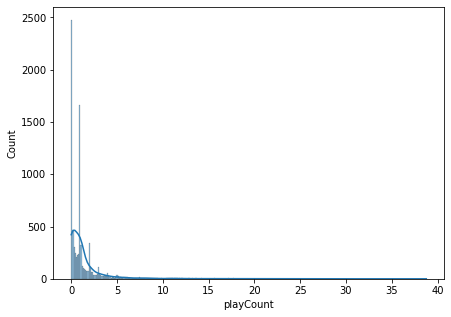

In [7]:
plot_hist(streams_features)

In [8]:
streams_features["playCount"].skew() #Prior to transformation

5.095245716380945

Trying to normalize the data through log transformation

In [9]:
#Removing outliers 
# streams_features = streams_features[streams_features["playCount"]<5]
# streams_features = streams_features[streams_features["playCount"]>=0.5]
# streams_features.count()
# sns.histplot(data = streams_features, x = "playCount", stat = "count", kde = True)

In [12]:
#Cap songs plays at 10

streams_features["playCount"].where(streams_features["playCount"] <= 10, 10, inplace=True)

/Users/James/.pyenv/versions/3.8.5/envs/ml_env/lib/python3.8/site-packages/pandas/core/generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(


<AxesSubplot:xlabel='playCount', ylabel='Count'>

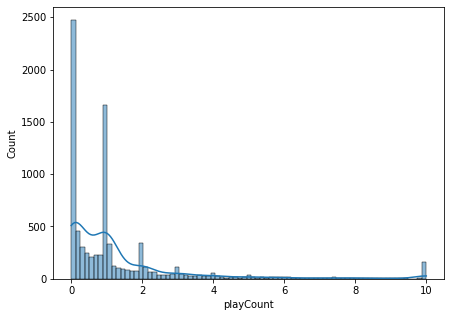

In [13]:
plot_hist(streams_features)

In [14]:
# fig, axs = plt.subplots(1,3,figsize=(12,5))
# sns.histplot(data = no_zeroes["playCount"], stat = "count", kde = True, ax = axs[0])
# sns.histplot(data = log_dist2, stat = "count", kde = True, ax = axs[1])
# sns.histplot(data = sqrt_dist, stat = "count", kde = True, ax = axs[2])

In [15]:
X = streams_features.drop(["artistName", "trackName", "minutesTotal", "trackId", "playCount"], axis = 1)
y = streams_features["playCount"]

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
standard_scalar  = StandardScaler()
min_max_scaler = MinMaxScaler()
#X = min_max_scaler.fit_transform(X)
X = standard_scalar.fit_transform(X)
#X = pt.fit_transform(X)

In [17]:
len(X)

8443

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42, shuffle = True)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.33, random_state=42, shuffle = True)

In [20]:
X_lengths = {"X_train" : len(X_train), "X_test" : len(X_test), "X_valid" : len(X_valid)}
y_lengths = {"y_train" : len(y_train), "y_test" : len(y_test), "y_valid" : len(y_valid)}

In [21]:
X_lengths, y_lengths

({'X_train': 3789, 'X_test': 2787, 'X_valid': 1867},
 {'y_train': 3789, 'y_test': 2787, 'y_valid': 1867})

In [22]:
len(X_train) + len(X_test) + len(X_valid)

8443

In [23]:
import tensorflow as tf
from tensorflow import keras

In [24]:
model_params = {
    "optimizer":keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-06, amsgrad=False,
    name='Adam'), 
    "loss": tf.keras.losses.MeanAbsoluteError(),
    "hidden_activation":"relu",
    "output_activation":"relu",  
    #"loss":keras.losses.Huber(), 
    "initializer" : tf.keras.initializers.HeNormal()
}

In [25]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05,
                              patience=2, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,min_delta = 0.001)

In [26]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation=model_params["hidden_activation"], input_shape=X_train.shape[1:], 
                       kernel_initializer=model_params["initializer"]),
    #keras.layers.Dense(40, activation=model_params["hidden_activation"]),
    #keras.layers.Dense(30, activation=model_params["hidden_activation"]),
    #keras.layers.Dense(30, activation=model_params["hidden_activation"],kernel_initializer=model_params["initializer"]),
    keras.layers.Dense(10, activation=model_params["hidden_activation"],kernel_initializer=model_params["initializer"]),
    keras.layers.Dense(1, activation=model_params["output_activation"]),
])

model.compile(loss=model_params["loss"], 
              optimizer=model_params["optimizer"])

In [27]:
loss_min = {}
val_loss_min = {}
for i in [250]:
    history = model.fit(X_train, 
                    y_train, 
                    epochs=i, 
                    verbose = 1, 
                    validation_data=(X_valid, y_valid),
                    callbacks = [reduce_lr,early_stopping],
                    batch_size = 16, 
                    shuffle = True)
    loss_min[i] = min(history.history["loss"])
    val_loss_min[i] = min(history.history["val_loss"])

Epoch 1/250
237/237 [==============================] - 1s 3ms/step - loss: 1.2633 - val_loss: 1.2578
Epoch 2/250
237/237 [==============================] - 1s 2ms/step - loss: 1.2207 - val_loss: 1.2456
Epoch 3/250
237/237 [==============================] - 0s 2ms/step - loss: 1.2109 - val_loss: 1.2411
Epoch 4/250
237/237 [==============================] - 0s 2ms/step - loss: 1.2047 - val_loss: 1.2356
Epoch 5/250
237/237 [==============================] - 0s 2ms/step - loss: 1.1989 - val_loss: 1.2303
Epoch 6/250
237/237 [==============================] - 1s 2ms/step - loss: 1.1932 - val_loss: 1.2244
Epoch 7/250
237/237 [==============================] - 1s 3ms/step - loss: 1.1877 - val_loss: 1.2191
Epoch 8/250
237/237 [==============================] - 0s 2ms/step - loss: 1.1819 - val_loss: 1.2137
Epoch 9/250
237/237 [==============================] - 0s 2ms/step - loss: 1.1765 - val_loss: 1.2083
Epoch 10/250
237/237 [==============================] - 1s 3ms/step - loss: 1.1693 - val_lo

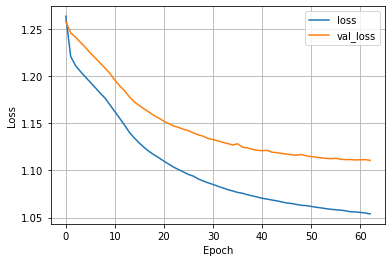

In [28]:
plot_loss(history, exp = False)

In [29]:
model.evaluate(x = X_test,  y = y_test, verbose=1, batch_size = 16)

175/175 [==============================] - 0s 1ms/step - loss: 1.1363


1.1362725496292114